In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'../..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

hyspeclab_dir = os.path.join(project_dir, 'HySpecLab')
if hyspeclab_dir not in sys.path:
    sys.path.append(hyspeclab_dir)

ipdl_dir = os.path.join(project_dir, 'modules/IPDL')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)

ae_dir = os.path.join(project_dir, 'modules/AutoEncoder')
if ae_dir not in sys.path:
    sys.path.append(ae_dir)

from matplotlib import pyplot as plt 
import numpy as np
import torch
import config
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from torchvision.transforms import ToTensor

def fill_noise(x, noise_type):
    """Fills tensor `x` with noise of type `noise_type`."""
    if noise_type == 'u':
        x.uniform_()
    elif noise_type == 'n':
        x.normal_() 
    else:
        assert False
        
def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
    """Returns a pytorch.Tensor of size (1 x `input_depth` x `spatial_size[0]` x `spatial_size[1]`) 
    initialized in a specific way.
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler. 
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
    if method == 'noise':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]]
        net_input = torch.zeros(shape)
        
        fill_noise(net_input, noise_type)
        net_input *= var            
    elif method == 'meshgrid': 
        assert input_depth == 2
        X, Y = np.meshgrid(np.arange(0, spatial_size[1])/float(spatial_size[1]-1), np.arange(0, spatial_size[0])/float(spatial_size[0]-1))
        meshgrid = np.concatenate([X[None,:], Y[None,:]])
        net_input=  ToTensor()(meshgrid)
    else:
        assert False
        
    return net_input

# Data

In [3]:
from scipy.io import loadmat

dataset_path = os.path.join(config.DERMA_DATASET_DIR, 'train/')
subjects = os.listdir(dataset_path)[::12]

subject_data = []
for i in subjects:
    mat = loadmat(os.path.join(dataset_path, i))
    subject_data.append(mat['preProcessedImage'].astype(np.float64)[np.newaxis,:])

subject_data = np.concatenate(subject_data)
mean_value = subject_data[np.logical_not(np.isnan(subject_data))].mean()
subject_data = np.nan_to_num(subject_data, nan=mean_value)

### Endmember Extraction

In [4]:
n_endmembers = 4

#### NFINDR

In [5]:
from pysptools import eea

ee = eea.NFINDR()
U = torch.tensor(ee.extract(subject_data.reshape(subject_data.shape[0]*subject_data.shape[1], subject_data.shape[2], -1), n_endmembers, maxit=1024, normalize=False,ATGP_init=True))

#### VCA

In [ ]:
from HySpecLab.eea import VCA

eea = VCA(n_endmembers)
data = subject_data.reshape(subject_data.shape[0]*subject_data.shape[1]*subject_data.shape[2], subject_data.shape[3])
eea.fit(data)
U = torch.tensor(eea.endmembers().T)

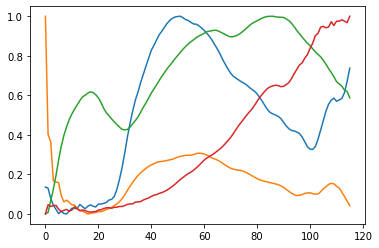

In [6]:
from matplotlib import pyplot as plt 
plt.plot(U.T)
plt.show()

In [7]:
from torchvision.transforms import Compose, ToTensor, Resize, InterpolationMode, Normalize

transform = Compose([
    ToTensor(),
    Resize((64,64), InterpolationMode.BILINEAR),
])

In [8]:
from torch.utils.data import Dataset 
from torchvision import transforms as torchTransforms

class TestDataset(Dataset):
    def __init__(self, data, transform=torchTransforms.Compose([torchTransforms.ToTensor()])):
        super(TestDataset, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.transform(self.data[idx])

train_set = TestDataset(subject_data, transform)

In [9]:
from torch.utils.data import DataLoader

loader = DataLoader(train_set, batch_size=32, shuffle=False)
X_tensor = next(iter(loader))

In [10]:
# X_tensor = torch.unsqueeze(transform(X_std), dim=0)
# X_tensor = torch.unsqueeze(transform(subject_data), dim=0)
noisy_input = []
for i in range(X_tensor.shape[0]):
    noisy_input.append(get_noise(X_tensor.shape[1], 'noise', X_tensor.shape[2:], noise_type='u'))

noisy_input = torch.cat(noisy_input, axis=0)

# U_tensor = torch.unsqueeze(U_std.T, dim=0).float()
U_tensor = torch.unsqueeze(U.T, dim=0).float()

print('Z shape: {}'.format(noisy_input.shape))
print('HyperCube shape: {}'.format(X_tensor.shape))
print('Endmember shape: {}'.format(U_tensor.shape))

Z shape: torch.Size([5, 116, 64, 64])
HyperCube shape: torch.Size([5, 116, 64, 64])
Endmember shape: torch.Size([1, 116, 4])


In [11]:
from HySpecLab.unmixing import UnDIP

n_bands = X_tensor.shape[1]
n_endmembers = U_tensor.shape[-1]

in_channels = [n_bands, 256]
out_channels = [n_bands, 128]
skip_channels = [8, 16]

model = UnDIP(in_channels, out_channels, skip_channels, n_endmembers)

100%|██████████| 5000/5000 [02:14<00:00, 37.18epoch/s, tls=0.0154]


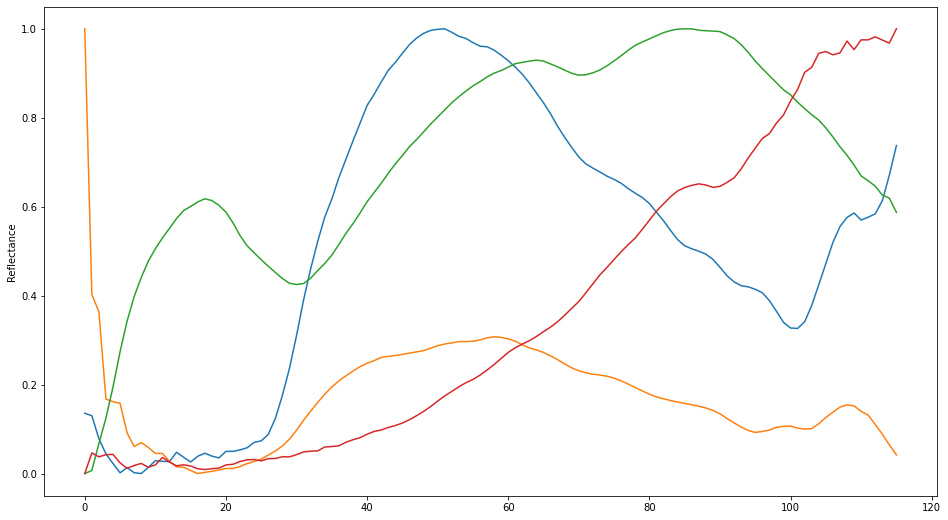

In [12]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from HySpecLab.utils import fig_to_image


batch_size = X_tensor.shape[0]
n_bands = X_tensor.shape[1]
w, h = X_tensor.shape[2:]

n_epoch = 5000
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
criterion = nn.MSELoss()

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

tb_writer = SummaryWriter('logs/test')

#Endmember signal image
fig, ax = plt.subplots(1,1, figsize=(16,9))

labels = list(map(lambda x: 'Endmember {}'.format(x), range(len(U))))
ax.plot(U.T, label=labels)
ax.set_ylabel('Reflectance')

image = ToTensor()(fig_to_image(fig)).unsqueeze(0)
tb_writer.add_image('Endmembers', image, dataformats='NCHW')


# Target Image
show_band_idx = np.linspace(0, X_tensor.shape[1]-1, num=16, dtype=np.int64)
for i in range(4):
    target_imgs = torch.unsqueeze(X_tensor[i, show_band_idx], dim=1)
    img_grid = make_grid(target_imgs)
    tb_writer.add_image('Target/{}'.format(i), img_grid, 0)


noisy_input = noisy_input.to(device)

for epoch in epoch_iterator:
    output = model(noisy_input)

    restoration = torch.matmul(U_tensor.to(device), output.flatten(start_dim=2)).reshape((output.shape[0], n_bands, w, h))

    if epoch % 100 == 0: # Cada 100 epoch
        for i in range(4):
            rest_imgs = torch.unsqueeze(restoration[i, show_band_idx], dim=1)
            img_grid = make_grid(rest_imgs)
            tb_writer.add_image('Output/{}'.format(i), img_grid, epoch)

            abundance_imgs = torch.unsqueeze(output[i], dim=1)
            img_grid = make_grid(abundance_imgs)
            tb_writer.add_image('Abundance/{}'.format(i), img_grid, epoch)

    batch_loss = criterion(restoration, X_tensor.float().to(device))

    epoch_iterator.set_postfix(tls="%.4f" % np.mean(batch_loss.detach().item()))
    tb_writer.add_scalar('Loss', batch_loss.detach().item(), epoch)

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    scheduler.step()

In [ ]:
from scipy.io import loadmat
mat = loadmat(os.path.join(config.DERMA_DATASET_DIR, 'train/P32_C1000.mat'))
X = mat['preProcessedImage'].astype(np.float64)

tiny_X = X.reshape((X.shape[0]*X.shape[1],X.shape[2]))

In [ ]:
from pysptools import eea

ee = eea.NFINDR()
U = torch.tensor(ee.extract(X, 6, maxit=1024, normalize=False,ATGP_init=True))

In [ ]:
from HySpecLab.transform import StandarizedTransform
std_transform = StandarizedTransform()

tiny_X_std = std_transform.fit_transform(tiny_X)
X_std = tiny_X_std.reshape(X.shape)
U_std = std_transform.transform(U)

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(12,3))
ax[0].plot(U.T)
ax[0].set_title('Original Endmember')
ax[1].plot(U_std.T)
ax[1].set_title('Standarized Endmember')
plt.show()

In [ ]:
# plt.plot(tiny_X[[100, 120, 200, 500]].T)
fig, ax = plt.subplots(1,2, figsize=(12,3))
ax[0].plot(tiny_X[[100, 120, 200, 500]].T)
ax[0].set_title('Original Data')
ax[1].plot(tiny_X_std[[100, 120, 200, 500]].T)
ax[1].set_title('Standarized Data')
plt.show()

In [ ]:
from torchvision.transforms import Compose, ToTensor, Resize, InterpolationMode, Normalize

transform = Compose([
    ToTensor(),
    Resize((64,64), InterpolationMode.NEAREST),
])

In [ ]:
# X_tensor = torch.unsqueeze(transform(X_std), dim=0)
X_tensor = torch.unsqueeze(transform(X), dim=0)
noisy_input = get_noise(X_tensor.shape[1], 'noise', X_tensor.shape[2:], noise_type='u')

# U_tensor = torch.unsqueeze(U_std.T, dim=0).float()
U_tensor = torch.unsqueeze(U.T, dim=0).float()

print('Z shape: {}'.format(noisy_input.shape))
print('HyperCube shape: {}'.format(X_tensor.shape))
print('Endmember shape: {}'.format(U_tensor.shape))

In [ ]:
from HySpecLab.unmixing import UnDIP

n_bands = X_tensor.shape[1]
n_endmembers = U_tensor.shape[-1]

in_channels = [n_bands, 256]
out_channels = [32, 128]
skip_channels = [4, 8]

model = UnDIP(in_channels, out_channels, skip_channels, n_endmembers)

# Train

In [ ]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

n_bands = X_tensor.shape[1]
w, h = X_tensor.shape[2:]

n_epoch = 10000
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
criterion = nn.MSELoss()

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

tb_writer = SummaryWriter('logs/test')
show_band_idx = np.linspace(0, X_tensor.shape[1]-1, num=16, dtype=np.int64)
target_imgs = torch.unsqueeze(X_tensor[0, show_band_idx], dim=1)
img_grid = make_grid(target_imgs)
tb_writer.add_image('Target', img_grid, 0)

noisy_input = noisy_input.to(device)

for epoch in epoch_iterator:
    output = model(noisy_input)

    restoration = torch.matmul(U_tensor.to(device), output.flatten(start_dim=2)).reshape((1, n_bands, w, h))

    rest_imgs = torch.unsqueeze(restoration[0, show_band_idx], dim=1)
    img_grid = make_grid(rest_imgs)
    tb_writer.add_image('Output', img_grid, epoch)

    abundance_imgs = torch.unsqueeze(output[0], dim=1)
    img_grid = make_grid(abundance_imgs)
    tb_writer.add_image('Abundance', img_grid, epoch)

    batch_loss = criterion(restoration, X_tensor.float().to(device))

    epoch_iterator.set_postfix(tls="%.4f" % np.mean(batch_loss.detach().item()))
    tb_writer.add_scalar('Loss', batch_loss.detach().item(), epoch)

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    scheduler.step()

In [ ]:
A = model(noisy_input)

In [ ]:
torch.save(A, 'Abundance.pt')

In [ ]:
A = torch.load('Abundance.pt')

In [ ]:
from torchvision.transforms import ToPILImage
from matplotlib import pyplot as plt

A = A.cpu().detach()
fig, ax = plt.subplots(4,6, figsize=(26,9))
for i in range(len(A[0])):
    if i >= 4:
        break
    
    for j in range(len(A[1])):
        ax[i, j].imshow(A[i,j])

    

In [ ]:
noisy_input.min()

# Testing